In [25]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score

%matplotlib inline

# Read data

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
all_df = train_df.append(test_df)

all_df['is_test'] = all_df.Survived.isnull()
all_df.index = all_df.Survived


In [3]:
all_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,is_test
Survived,,,,,,,,,,,,,
0,22,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171,False
1,38,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599,False
1,26,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282,False
1,35,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803,False
0,35,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450,False


# Target variable

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Target variable is **Survived**.

# Quality metric

Your score is the percentage of passengers you correctly predict. That means - **accuracy**.

# Model

## One variable model
Let's build a very simple model, based on one variable.
That nobody will survived.

In [9]:
def select_features(df):
    non_obj_feats = df.columns[ df.dtypes != 'object' ]
    black_list = ['PassengerId', 'is_test', 'Survived']
    
    return [feat for feat in non_obj_feats if feat not in black_list ]

def get_X_y(df):
    feats = select_features(df)
    
    X = df[feats].values
    y = df.index.values.astype(int)
    
    return X, y

def check_quality(model, X, y, n_folds=5, random_state=0, shuffle=True):
    skf = StratifiedKFold(y, n_folds=n_folds, random_state=random_state, shuffle=shuffle)
    scores = []
    
    for train_index, test_index in skf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        
        scores.append(score)
        
    return np.mean(scores), np.std(scores)

def train_and_verify(df, model):
    X, y = get_X_y( df[ df.is_test == False ] )
    return check_quality(model, X, y)

def iteration_modeling(all_df, model = RandomForestClassifier(), iterations=300):
    res = [train_and_verify(all_df, model)[0] for x in range(iterations)]
    return {'min': np.min(res), 'mean': np.mean(res), 'max': np.max(res) }

def get_importance_features(data, model, limit):
    X,y = get_X_y(data)
    cols = select_features(data)
    
    model.fit(X, y)
    feats = pd.DataFrame(model.feature_importances_, index=data[cols].columns)
    feats = feats.sort([0], ascending=False) [:limit]
    return feats.rename(columns={0:'feature'})
    
def draw_importance_features(data, model=RandomForestClassifier(), limit=30):
    feats = get_importance_features(data, model, limit)
    feats.plot(kind='bar', figsize=(20, 8))

In [6]:
class SingleVariableModel(BaseEstimator, ClassifierMixin):
    def __init__(self, seed=1):
        np.random.seed(seed)

    def fit(self, X, y):
        return self
        
    def predict(self, X):
        
        
        return [0] * len(X)
    
    def __repr__(self):
        return 'SingleVariableModel'

## Run & evoluate single variable model

In [7]:
train_and_verify(all_df, SingleVariableModel())

(0.61616490890978648, 0.0015536004208290756)

**What do you think about this result?**

## Let's build more advanced model

### Missing values
There're several methods how to manage missing values, let's fill out -1.

In [8]:
all_df.fillna(-1, inplace=True)

In [10]:
iteration_modeling(all_df)

{'max': 0.70819423594760877,
 'mean': 0.68713759526281004,
 'min': 0.66330648378760526}

The result looks better than previous one (**0.616** vs **0.68**).  
Let's improve it... by using those features `['Cabin', 'Embarked', 'Name', 'Sex', 'Ticket']`

In [11]:
if 'sex_male' not in all_df:
    one_hot = pd.get_dummies( all_df.Sex, prefix='sex')
    all_df = pd.concat( [all_df, one_hot], axis=1 )

In [13]:
iteration_modeling(all_df)

{'max': 0.81710274570384223,
 'mean': 0.79777930862626623,
 'min': 0.78115332824784278}

The result looks better than previous one (**0.68** vs **0.79**).  

Next features wchich could improve quality the model

In [14]:
all_df[ ['Name', 'Cabin', 'Embarked', 'Ticket'] ].head()

,Name,Cabin,Embarked,Ticket
Survived,,,,
0,"Braund, Mr. Owen Harris",-1,S,A/5 21171
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C85,C,PC 17599
1,"Heikkinen, Miss. Laina",-1,S,STON/O2. 3101282
1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",C123,S,113803
0,"Allen, Mr. William Henry",-1,S,373450


Prefix in names, let's try use it.

In [15]:
all_df['prefix_name'] = all_df['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip().lower() )

In [16]:
all_df['prefix_name'].value_counts()

mr              757
miss            260
mrs             197
master           61
dr                8
rev               8
col               4
ms                2
mlle              2
major             2
lady              1
sir               1
mme               1
capt              1
don               1
jonkheer          1
dona              1
the countess      1
dtype: int64

Let's use **mr**, **miss**, **mrs**, **master** and *other*

In [17]:
all_df['prefix_name_'] = all_df['prefix_name'].map(lambda x: x if x in ["mr", "miss", "mrs", "master"] else "other" )

In [18]:
all_df['prefix_name_'].value_counts()

mr        757
miss      260
mrs       197
master     61
other      34
dtype: int64

In [19]:
if 'title_master' not in all_df:
    one_hot = pd.get_dummies(all_df['prefix_name_'], prefix='title')
    all_df = pd.concat( [all_df, one_hot], axis=1 )

In [20]:
iteration_modeling(all_df)

{'max': 0.82827571727935489,
 'mean': 0.81078071582475308,
 'min': 0.79016755520895721}

The result looks better than previous one (**0.79** vs **0.81**).  

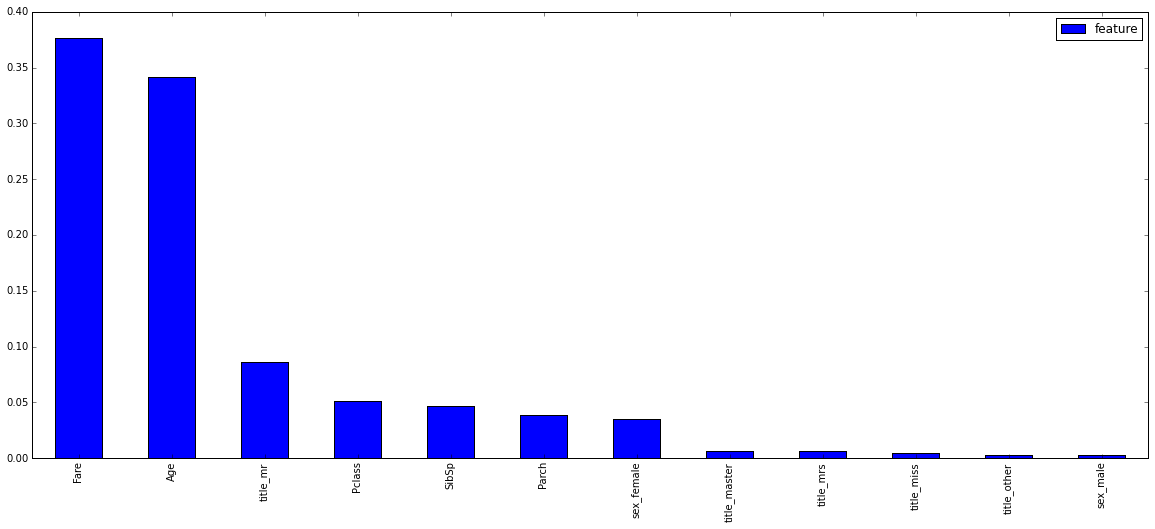

In [27]:
draw_importance_features(all_df)

Let's extract first letter from **Cabin**

In [28]:
all_df['cabin_index'] = pd.factorize(all_df.Cabin)[0]

all_df['deck_index'] = all_df['Cabin'].map(lambda x:  "missing" if x == -1 else x.strip()[0])
all_df['deck_index'].value_counts()

missing    1014
C            94
B            65
D            46
E            41
A            22
F            21
G             5
T             1
dtype: int64

In [29]:
if 'deck_C' not in all_df:
    one_hot = pd.get_dummies(all_df['deck_index'], prefix='deck')
    all_df = pd.concat( [all_df, one_hot], axis=1 )

In [30]:
iteration_modeling(all_df)

{'max': 0.82604778304176885,
 'mean': 0.80605447125379803,
 'min': 0.7822961095997677}

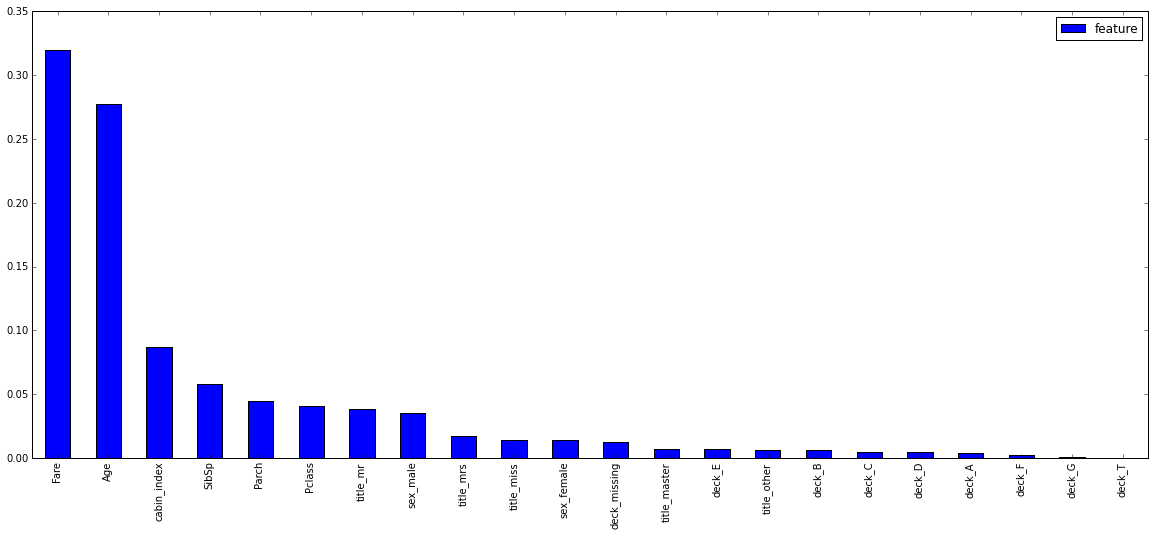

In [31]:
draw_importance_features(all_df)

The result looks the same or a bit worse (**0.81** vs **0.81**).
Let's focus on **Embarked**

In [33]:
all_df['Embarked'].replace(-1, 'missing', inplace=True)
if 'embarked_S' not in all_df:
    one_hot = pd.get_dummies(all_df['Embarked'], prefix='embarked')
    all_df = pd.concat( [all_df, one_hot], axis=1 )

In [34]:
iteration_modeling(all_df)

{'max': 0.82377534189639134,
 'mean': 0.80484710606392129,
 'min': 0.78230252852431759}

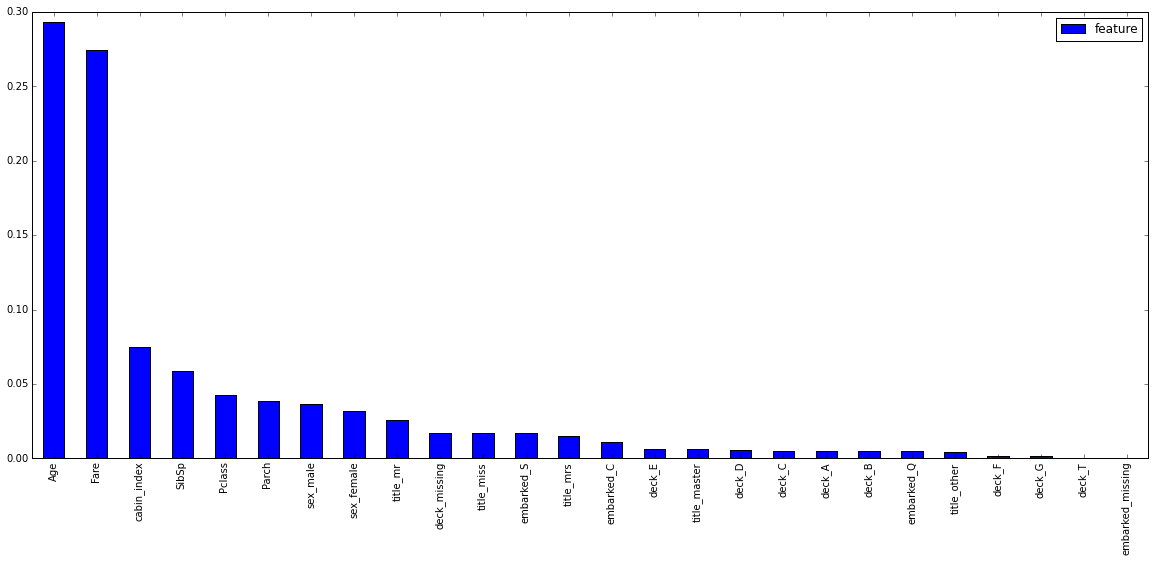

In [36]:
draw_importance_features(all_df)

Looks more or less the same (event a bit worse)... let's focus on the **Parch** and **SibSp**

* **Sibsp** - Number of Siblings/Spouses Aboard
* **Parch** - Number of Parents/Children Aboard

In [37]:
all_df['Parch'].value_counts()

0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
dtype: int64

In [38]:
all_df['SibSp'].value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
dtype: int64

In [40]:
all_df['sigle'] = all_df.apply(lambda x: 1 if x['Parch'] == x['SibSp'] else 0, axis=1)
all_df['count_relations'] = all_df['Parch'] + all_df['SibSp']

all_df['family_index'] = all_df.apply(lambda x: 'nofamily' if x['count_relations'] == 0 else '{0}-{1}'.format(x['Name'].split(',')[0].strip(), x['count_relations']), axis=1)

In [41]:
iteration_modeling(all_df)

{'max': 0.82157216130154498,
 'mean': 0.80137875567669947,
 'min': 0.78452425661938296}

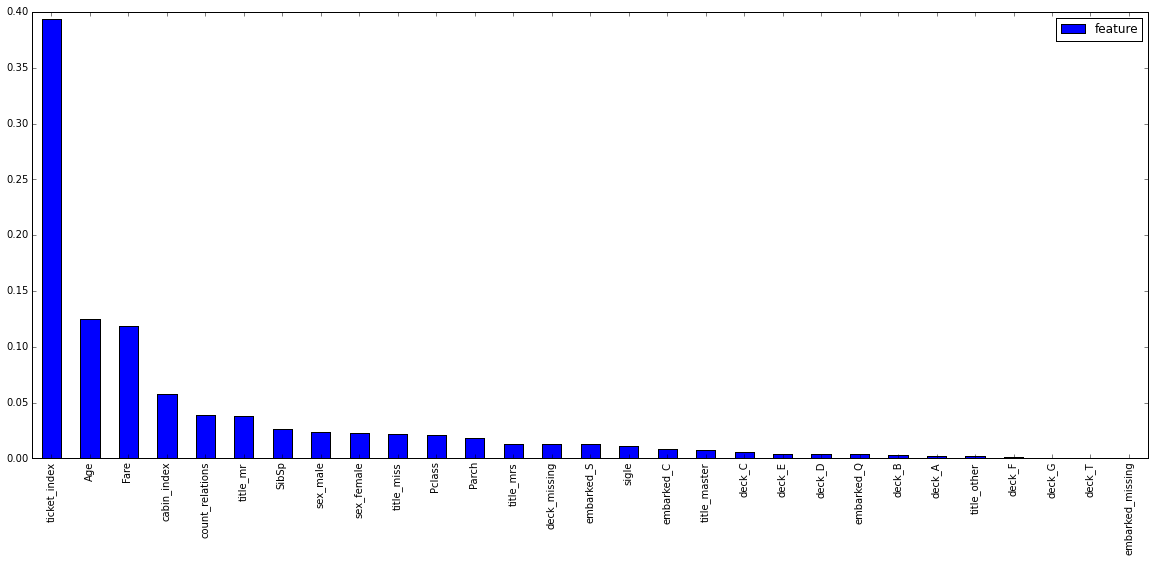

In [307]:
draw_importance_features(all_df)

Looks more or less the same, let's focus on ticket

In [43]:
ticket_idx, ticket_labels = pd.factorize(all_df.Ticket)
all_df['ticket_index'] = ticket_idx

In [44]:
iteration_modeling(all_df)

{'max': 0.82269604051653533,
 'mean': 0.80619777403990689,
 'min': 0.78788248899650937}

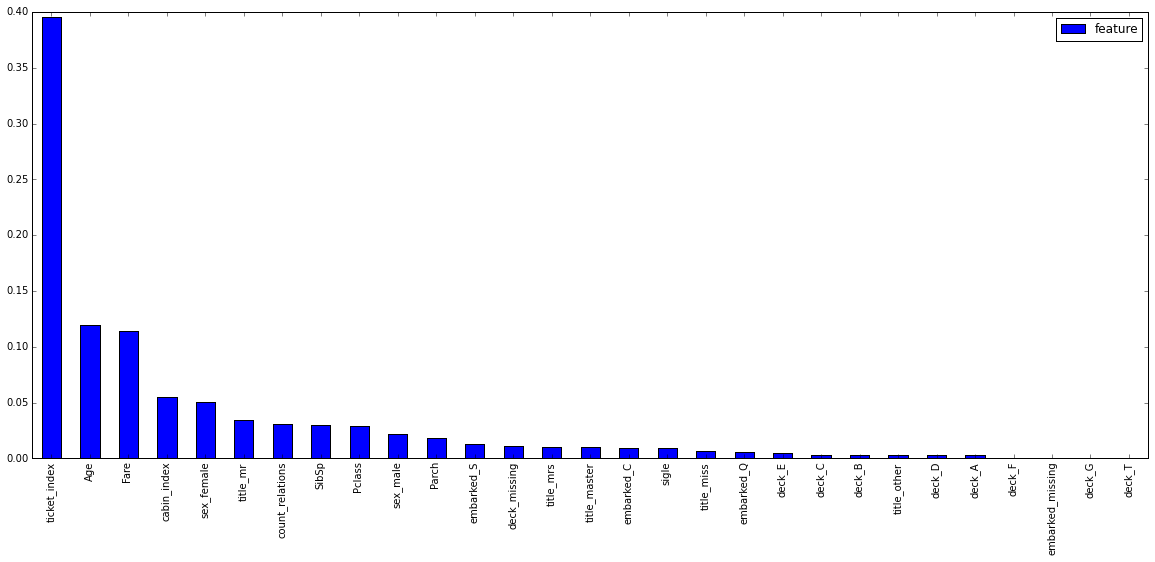

In [45]:
draw_importance_features(all_df)

Looks lik **title_index** is very important feature... This make sense, because the same number in ticket usually has a big impact on surviving.

**Fare** has a big impact, let's manage better missing value in **Fare**. 

In [70]:
print 'mean'
all_df.groupby(['Pclass', 'Sex']).agg(np.mean)['Fare'].reset_index()

mean


,Pclass,Sex,Fare
0,1,female,109.412385
1,1,male,69.888385
2,2,female,23.234827
3,2,male,19.904946
4,3,female,15.324250
5,3,male,12.388250


In [71]:
print 'median'
all_df.groupby(['Pclass', 'Sex']).agg(np.median)['Fare'].reset_index()

median


,Pclass,Sex,Fare
0,1,female,80.92915
1,1,male,49.50420
2,2,female,23.00000
3,2,male,13.00000
4,3,female,10.48960
5,3,male,7.89580


Interesting... for some reason the tickets are bought by female is more expensive.

In [84]:
def call_diff(x, dict_fare, percentage=False):
    key = (x['Pclass'], x['Sex'])
    diff = x['Fare'] - dict_fare[key]
    
    diff_per = np.abs(diff / x['Fare']) if x['Fare'] > 0 else 0.0
    return diff_per if percentage else diff

fare_median = all_df.groupby(['Pclass', 'Sex']).agg(np.median)['Fare'].to_dict()
fare_mean = all_df.groupby(['Pclass', 'Sex']).agg(np.mean)['Fare'].to_dict()

all_df['diff_fare_median'] = all_df.apply(lambda x: call_diff(x, fare_median), axis=1)
all_df['diff_fare_mean'] = all_df.apply(lambda x: call_diff(x, fare_mean), axis=1)
all_df['diff_fare_mm'] = all_df['diff_fare_median'] - all_df['diff_fare_mean']
all_df['diff_fare_median_pr'] = all_df.apply(lambda x: call_diff(x, fare_median, True), axis=1)
all_df['diff_fare_mean_pr'] = all_df.apply(lambda x: call_diff(x, fare_mean, True), axis=1)

In [87]:
iteration_modeling(all_df)

{'max': 0.82834540339394425,
 'mean': 0.80809623540123177,
 'min': 0.78677151855796201}

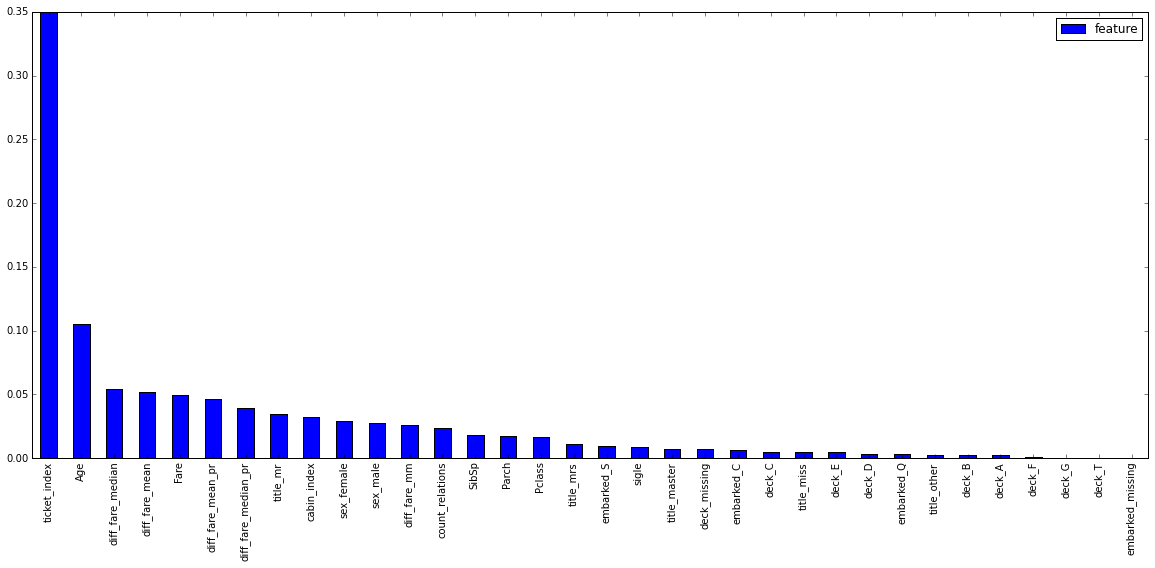

In [86]:
draw_importance_features(all_df, limit=50)